Walk trees part 1: zzStructures and PMZZSes
----------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 1.2020
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/timthelion/rust-walk-trees) [ipynb](./walk-trees.ipynb)

Walk trees are a novel algorithm for selecting regions of graphs.

Motivation
---------------

I am working on a project which allows end users to interact with arbitrary, larger than memory, graph-like data structures. There many peices of software which draw graphs. When it comes to software which specifically focuses on displaying larger graphs there are two approaches:

1. Display everything and allow zooming and panning.

I'd point to [Gephi](https://gephi.org/screenshots/) which allows you to visualize and algorithmically analyze large complex graphs.

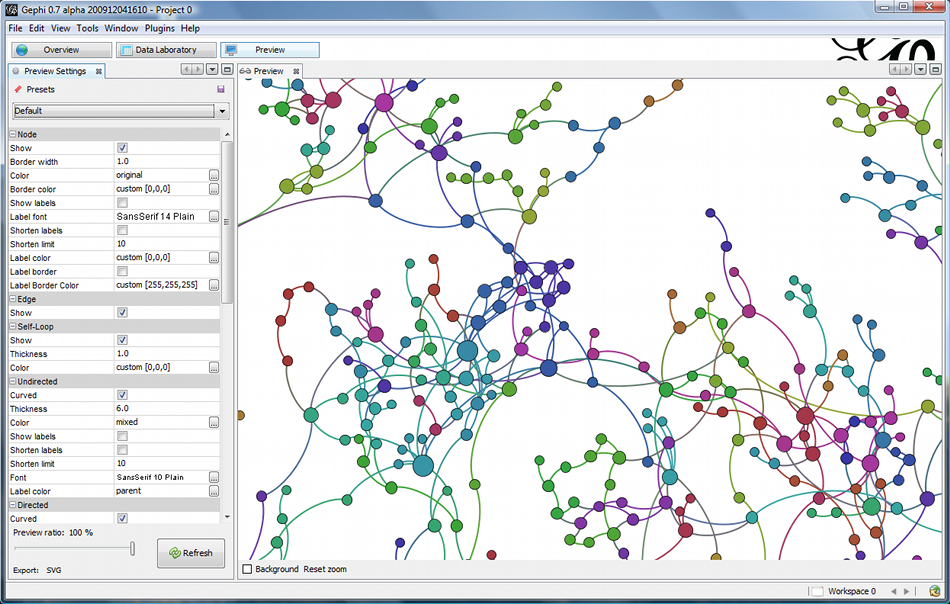
(screenshot taken directly from gephi homepage.)

And the graph database [neo4j](http://neo4j.com/)'s graph browser:

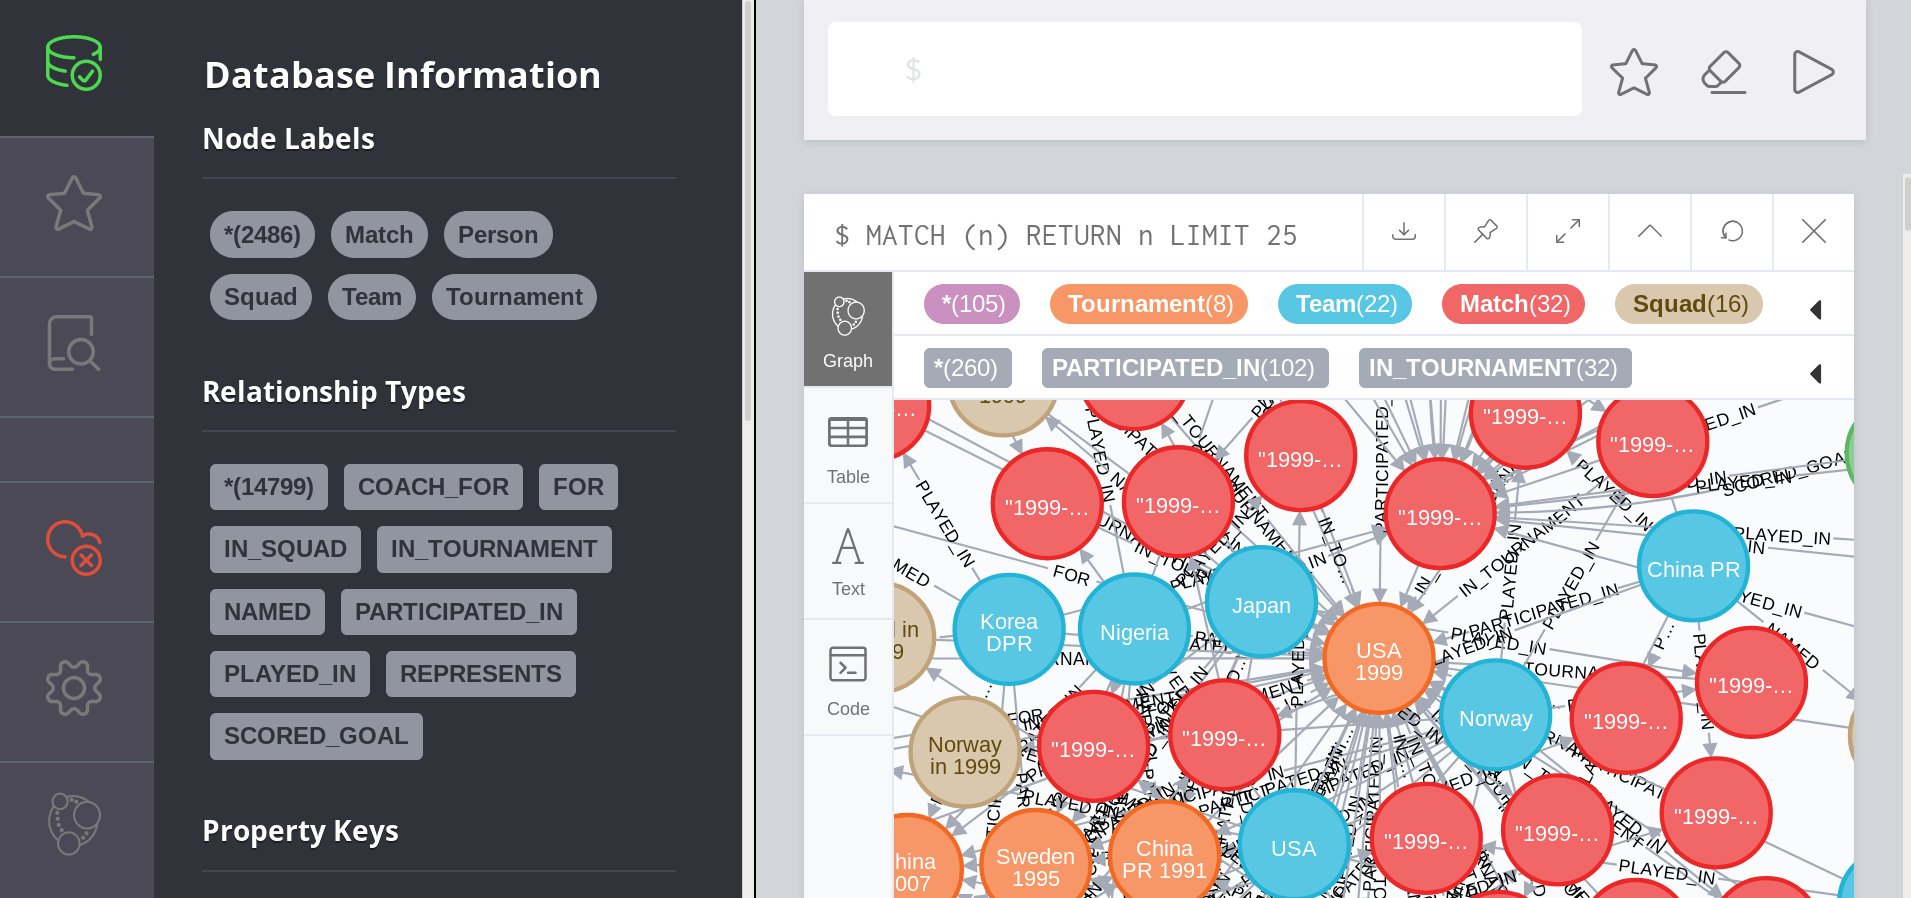

2. Display a "center" node and everything that is a close neighbor of that node

You can play with an interactive version of this model at [webbrain.com](https://webbrain.com/brainpage/brain/C6015FA0-82BF-F1FA-9D05-0EA9FD7F845E#-2751)

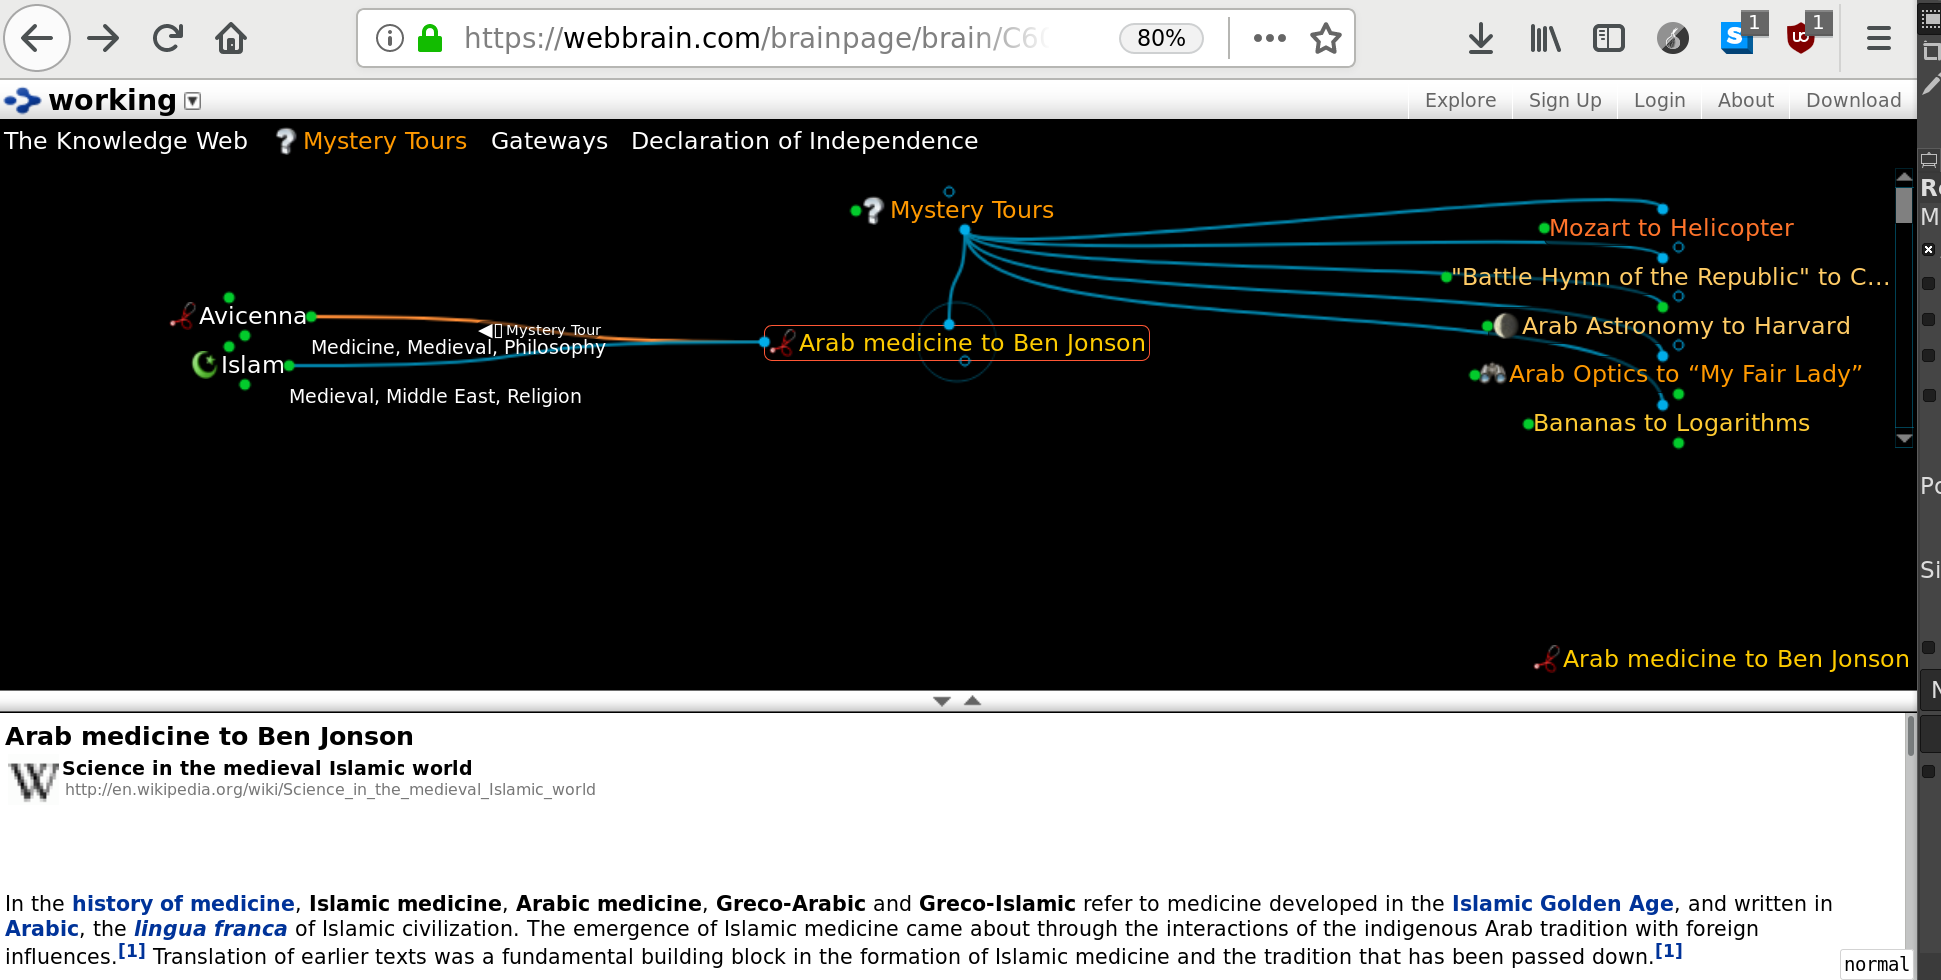

To me, the most important take away for me are the trade offs:

Displaying everything can lead to insights about the overall structure of the data, but at the same time, it often leads to a jumble of nodes and edges from which nothing can be seen because everything is just way to cluttered. Interacting with the graph requires a mouse and editing the graph seems impractical.

Displaying just a small section of the graph conceals the overall structure of the graph, but allows you to explore graphs which would be otherwise impossible to display using the zooming and panning view. There is still no clear way to edit the graph.

The origional goal of the walk-trees algorithm was to build off the second display method. I wanted to create a method for selecting regions of graphs which are:

1. Centered around a given node/vertex
2. Possible to draw on a screen
3. Deterministically defined
4. Quickly and efficiently selected
5. Configurable, with the possiblility of define different "shapes" (topologies) of region with different desired properties and it should be possible to send these "shapes" over a network without requiring too much bandwidth, in order to "query" a remote graph for a region to be displayed.
6. Lacking in run-away conditions in which "too many" nodes would be selected
7. Securely configurable, in that all region queries should complete in finite time

I started from an absract perspective:

 - I have a "too large to draw on the screen" graph: `G`
 - A function `shapes` which iterates over all possible drawable graphs, starting from the largest most complex shapes and moving to smaller ones.
 - A function `fit_shape` which would look for subgraph isomorphisms between the iteratited shapes and `G`
 
There were imediately several problems that came to mind. 

1. The set of all drawable `shapes` would probably be very large
2. Fitting subgraph isomorphisms is computationally expensive
3. Since the regions should have a center vertex that should be pinned within `G`, standard subgraph isomorphism algorithms would have to be adapted
4. How do we even iterate over drawable `shapes`? We need to define what is drawable somehow.

Towards walk trees
---------------------------

As I stated previously, another goal of mine was to make an interface which could be easilly interacted with using a keyboard. As inspiration I had two related projects:

1. [zigzag](http://xanadu.com/zigzag/)
2. [fenfire](https://web.archive.org/web/20160330102314/http://fenfire.org/) [source](https://github.com/timthelion/fenfire)

Zigzag is a previously [patent encumbered](https://patents.google.com/patent/US6262736) free software project which was auteured by (patent holder) Ted Nelson and programmed by a number of enthusiastic volunteer coders. The project ended when Nelson withdrew his blessing and permission to use the patent. The patent is now expired.

Zigzag uses a structure called a `zzStructure` directed graphs which are of degree `2 * dim` where `dim` is the number of "dimensions" in the graph. For each vertex there is at most one incomming and one outgoing edge per dimension. When drawn so that there are 2 dimensions showing, the graph can be navigated using 4 arrow keys.

You can see a video demonstration of Zigzag here: https://www.youtube.com/watch?v=WEj9vqVvHPc

Any directed graph can be converted to a zzStructure. Here is an algorithm for doing so.

In [2]:
:dep petgraph = "0.4.13"

In [3]:
:dep petgraph-evcxr = "*"

In [4]:
extern crate petgraph;
use petgraph::graph::Graph;
use petgraph::dot::Dot;
use crate::petgraph::visit::*;
use petgraph::data::*;
use petgraph::*;
use petgraph_evcxr::draw_graph;

Given a graph like so:

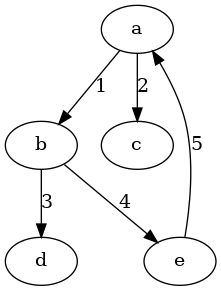

In [5]:
let mut g : Graph<&str, &str, petgraph::Directed> = Graph::new();
let g_item1 = g.add_node("a");
let g_item2 = g.add_node("b");
let g_item3 = g.add_node("c");
let g_item4 = g.add_node("d");
let g_item5 = g.add_node("e");
g.add_edge(g_item1, g_item2, "1");
g.add_edge(g_item1, g_item3, "2");
g.add_edge(g_item2, g_item4, "3");
g.add_edge(g_item2, g_item5, "4");
g.add_edge(g_item5, g_item1, "5");
draw_graph(&g);

Add two vertexs per edge. In visual programming, these new vertex's are called *ports*.

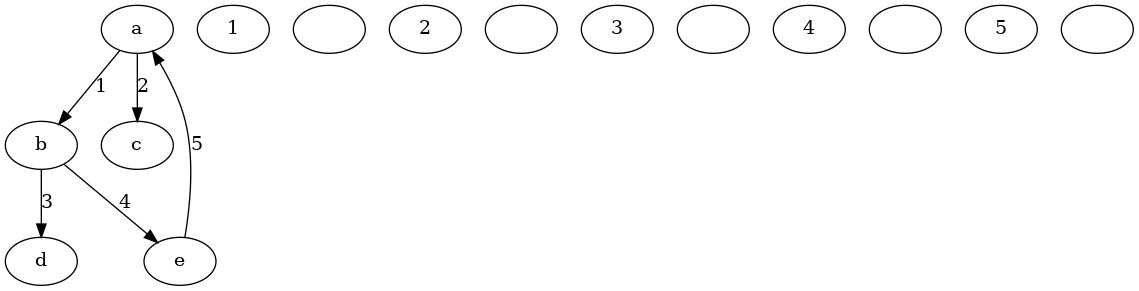

In [6]:
let mut zzg_1 = g.clone();
for er in g.edge_references() {
    zzg_1.add_node(er.weight());
    zzg_1.add_node("");
}
draw_graph(&zzg_1);

The ports are then connected together into singly linked lists. For example, the node `a` has two outgoing ports: `1` and `2` and one incomming port, connected to `e`'s `5` port.
Lets connect the incomming out outgoing ports and link up the port lists.

In order to properly convert to a zzStructure, we need to label our edges with their repsective dimensions as well. Here I use two dimensions which I refer to as NS(↑North↓South) and EW(→East←West)

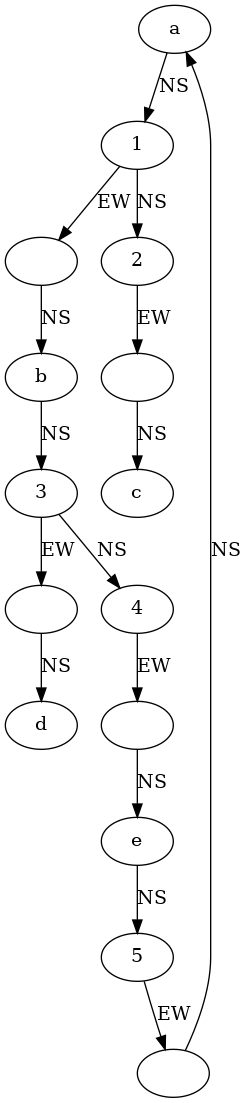

In [7]:
use std::collections::HashMap;
use std::fmt;

#[derive(Debug, PartialEq, Clone)]
enum Dimension {
    NS,
    EW,
}

impl fmt::Display for Dimension {
    fn fmt(&self, f: &mut fmt::Formatter<'_>) -> fmt::Result {
        write!(f, "{:?}", self)
    }
}

fn to_pmzzs<'a, G, W, E, N>(g: &'a G, blank: W) -> Graph<W, Dimension, petgraph::Directed>
where
    W: Clone,
    &'a G: IntoEdgeReferences
        + IntoNodeReferences
        + Data<NodeWeight = W, EdgeWeight = W>
        + GraphBase<EdgeId = E, NodeId = N>,
    G: Build,
    N: Eq + Copy + std::hash::Hash,
    E: Eq + Copy,
    W: Clone,
{
    let mut last_outgoing_port = HashMap::new();
    let mut last_incomming_port = HashMap::new();
    let mut node_map = HashMap::new();
    let mut zzg: Graph<W, Dimension, petgraph::Directed> = Graph::new();
    for nr in g.node_references() {
        let new_id = zzg.add_node(nr.weight().clone());
        node_map.insert(nr.id(), new_id);
    }
    for er in g.edge_references() {
        let outgoing = zzg.add_node(er.weight().clone());
        let incomming = zzg.add_node(blank.clone());
        zzg.add_edge(outgoing, incomming, Dimension::EW);
        // Connect outgoing port list
        match last_outgoing_port.get(&er.source()) {
            Some(prev) => {
                zzg.add_edge(*prev, outgoing, Dimension::NS);
            }
            None => {        
                zzg.add_edge(*node_map.get(&er.source()).unwrap(), outgoing, Dimension::NS);
            }
        }
        last_outgoing_port.insert(er.source(), outgoing);
        // Connect incomming port list
        match last_incomming_port.get(node_map.get(&er.target()).unwrap()) {
            Some(prev) => {
                zzg.add_edge(incomming, *prev, Dimension::NS);
            }
            None => {        
                zzg.add_edge(incomming, *node_map.get(&er.target()).unwrap(), Dimension::NS);
            }
        }
        last_incomming_port.insert(*node_map.get(&er.target()).unwrap(), outgoing);
    }
    zzg
}

let zzg_2 = to_pmzzs(&g, "");
//let undirected_zzg : Graph<&str, &str, petgraph::Undirected> = unsafe {std::mem::transmute(zzg_2.clone())};
draw_graph(&zzg_2);

I'll be refering to this as a "port model zzStructure representation of a directed graph with labled and ordered edges" or PMZZS for short throughout the rest of this article.

Now this PMZZS looks like a bit of a mess, but it has a few nice properties. One of which is that the [maximum degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)) of this graph is 3. Graphs which have been converted to PMZZS's can be redrawn as follows:

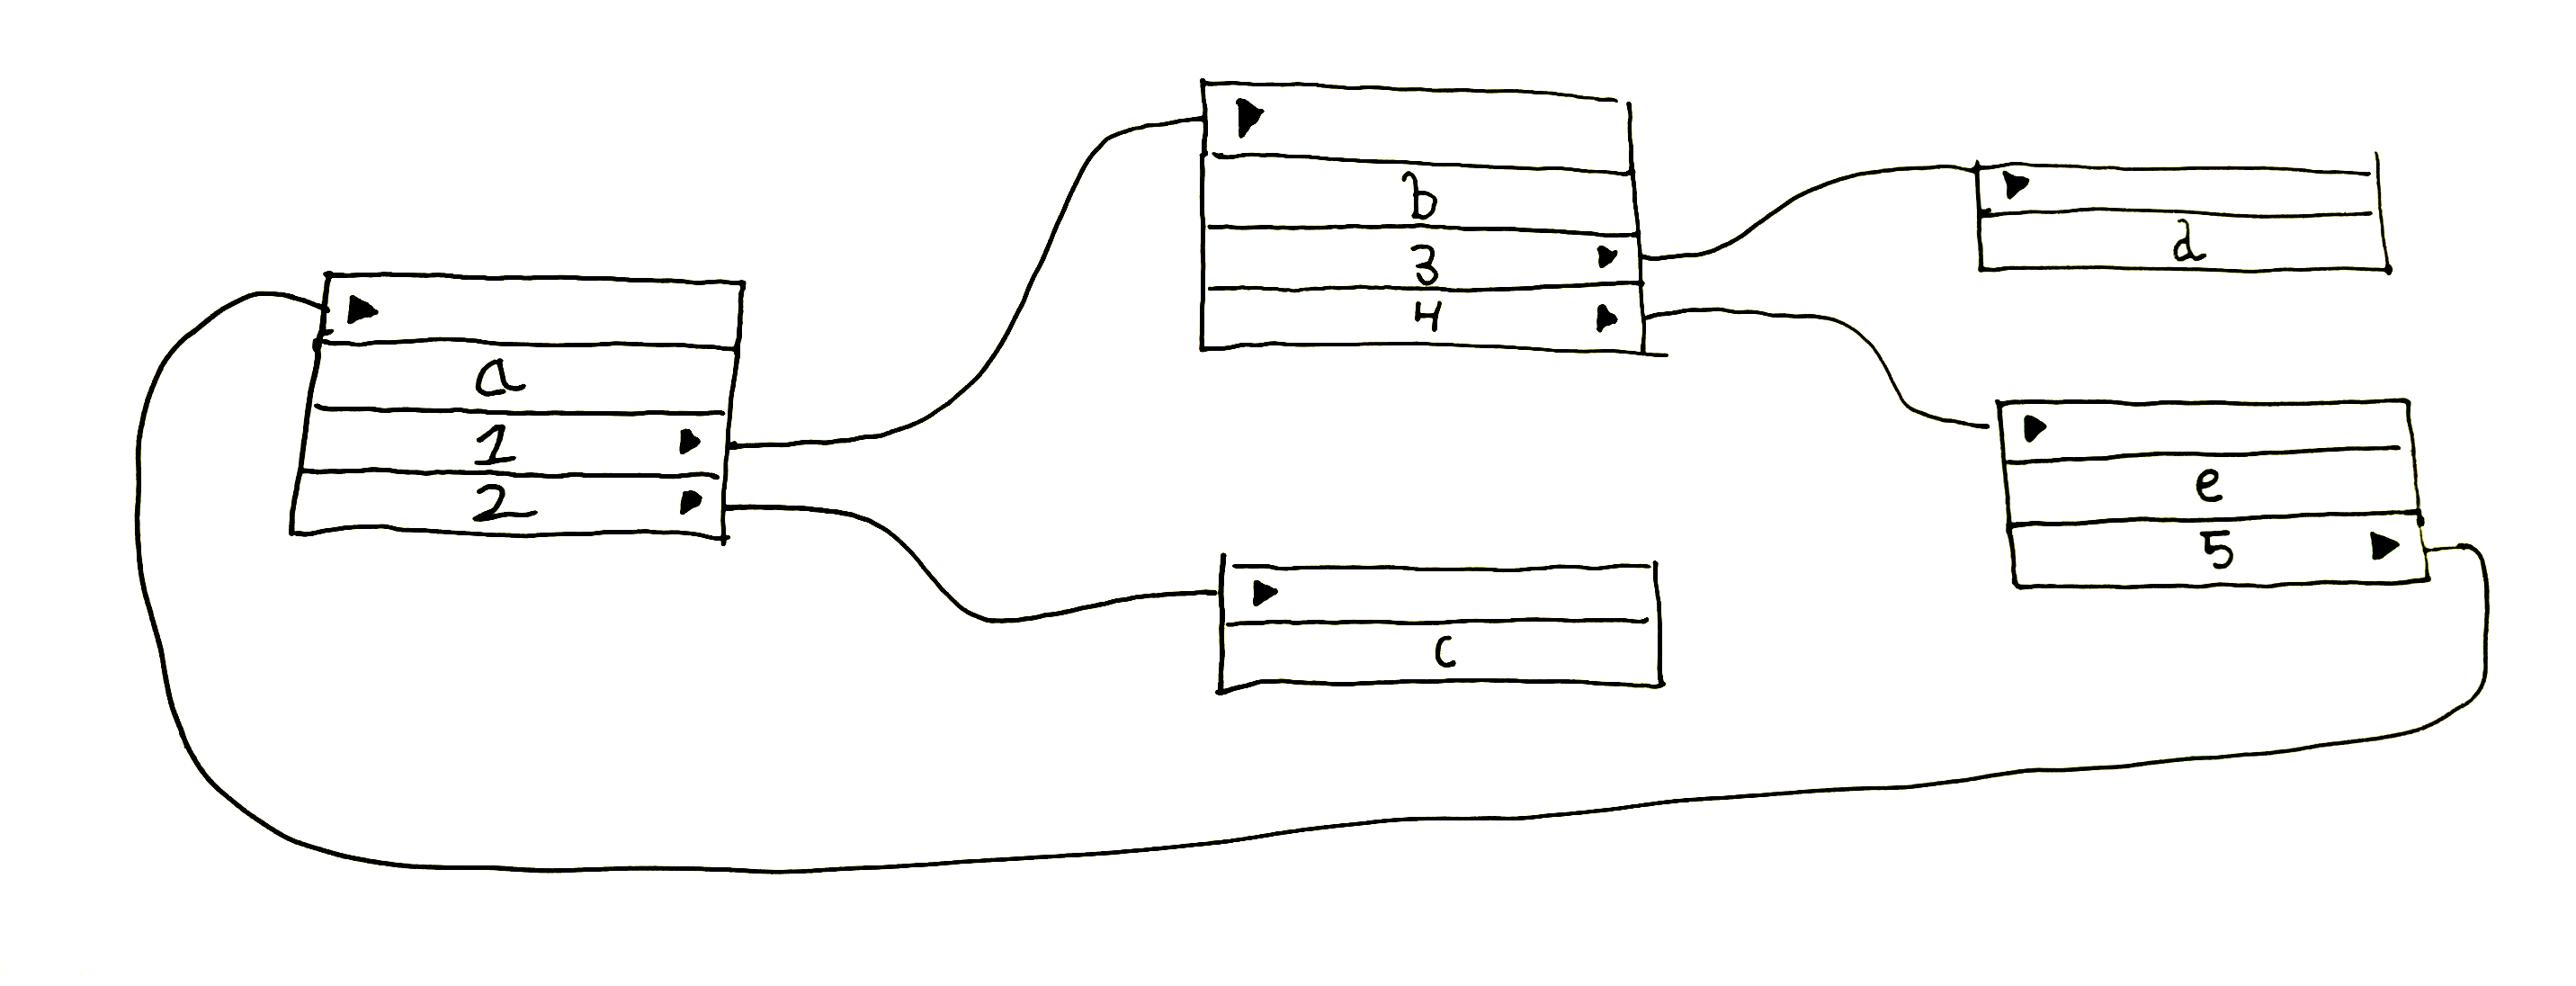

Any PMZZS can be converted unambiguiously back to a graph easilly via a process of [contraction, deletion](https://en.wikipedia.org/wiki/Graph_minor) and relabeling.

It shouldn't be any surprise that any graph can be represented using zzStructures. In fact, similar to the concept of turing completeness, in your computer everything is just represented by bits in the end. The fact that there is a 1:1 method of converting from directed graph to zzStructure tells us NOTHING, because there are an infinte number of way to encode any dynamically sized data structure as any other dynamically sized data structure.

What is interesting about PMZZS though, is that they share many properties with the graphs that they correspond to.

- A PMZZS has an isomorphism with another PMZZS [iff](https://en.wikipedia.org/wiki/If_and_only_if) the coresponding graphs have an isomorphism
- There is a path between two nodes in a PMZZS iff it's corresponding graph has a path between those two nodes
- The PMZZS of a graph has the same number of strongly connected components
- A PMZZS is only planar if its corresponding graph is planar
- A PMZZS is a tree iff its corresponding graph is a tree
- A PMZZS is a DAG iff its corresponding graph is a DAG
- And so on

PMZZS are not the same as their corresponding graphs. For example, shortest path algorithms will not come up with the same result, even if we ignore the fact that the edge weights have been moved to vertexes. However, PMZZS are really very similar in many many ways to their corresponding graphs and if we want to ask questions about graphs, we can sometimes answer those questions by working with their PMZZSes instead.

What follows is a function for converting from a PMZZS to its corresponding graph:

In [8]:
fn from_pmzzs<'a, W>(zzg: &'a Graph<W, Dimension, petgraph::Directed>) -> Graph<W, W, petgraph::Directed> 
where
 W: PartialEq + Clone,
{
    #[derive(Debug, PartialEq, Clone)]
    enum NType {
        OutgoingEdge,
        IncomingEdge,
        Vertex,
    }
    let mut gfz: Graph<W, W, petgraph::Directed> = Graph::new();
    let mut node_map = HashMap::new();
    let mut incoming_edges: Vec<petgraph::prelude::NodeIndex> = Vec::new();
    let mut outgoing_edges: Vec<petgraph::prelude::NodeIndex> = Vec::new();
    for nr in zzg.node_references() {
        let mut ntype = NType::Vertex;
        for edge in zzg.edges(nr.id()) {
            if *edge.weight() == Dimension::EW {
                ntype = NType::OutgoingEdge;
            }
        }
        for edge in zzg.edges_directed(nr.id(), Incoming) {
            if *edge.weight() == Dimension::EW {
                ntype = NType::IncomingEdge;
            }
        }
        //println!("{:?}", ntype);
        match ntype {
            NType::OutgoingEdge => {
                outgoing_edges.push(nr.id());
            },
            NType::IncomingEdge => {
                incoming_edges.push(nr.id());
            },
            NType::Vertex => {
                node_map.insert(nr.id(), gfz.add_node(nr.weight().clone()));
            },
        }
    }
    let mut outgoing_edge_map = HashMap::new();
    for (edge, node) in outgoing_edges.iter().map(|edge| {
            let mut node = *edge;
            while !node_map.contains_key(&node) {
                for e in zzg.edges_directed(node, Incoming) {
                    if *e.weight() == Dimension::NS {
                        node = e.source();
                    }
                }
            }
            (edge, node)
        }
    ) {
        outgoing_edge_map.insert(edge, node);
    }
    let mut incoming_edge_map = HashMap::new();
    for (edge, node) in incoming_edges.iter().map(|edge| {
            let mut node = *edge;
            while !node_map.contains_key(&node) {
                for e in zzg.edges_directed(node, Outgoing) {
                    if *e.weight() == Dimension::NS {
                        node = e.target();
                    }
                }
            }
            (edge, node)
        }
    ) {
        incoming_edge_map.insert(edge, node);
    }
    for (edge, source) in outgoing_edge_map {
        for e in zzg.edges_directed(*edge, Outgoing) {
            if *e.weight() == Dimension::EW {
                gfz.add_edge(
                    source,
                    *incoming_edge_map.get(&e.target()).unwrap(),
                    zzg.node_weight(*edge).unwrap().clone(),
                );
            }
        }
    }
    gfz
}

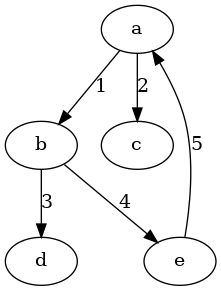

In [9]:
draw_graph(&from_pmzzs(&zzg_2));

Now lets look at zzStructures more generally. I'll start with an algorithm for drawing them with less mess. We start by dividing up the zzStructure into vertical stacks.

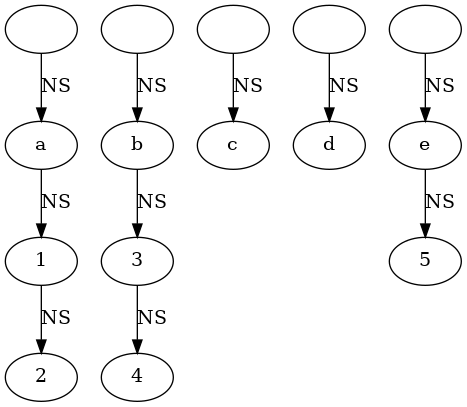

In [10]:
let stacks = zzg_2.filter_map(
    |_, n| Some(n.clone()),
    |_, e| match e {
        Dimension::EW => None,
        Dimension::NS => Some(Dimension::NS),
});
draw_graph(&stacks);

Next we convert the stacks to [graphviz html tables](https://stackoverflow.com/questions/13369992/graphviz-how-can-i-create-edges-between-html-table-cells) and we hook up the "ports", or since this is a more general case, we just hook up the horizontal edges.

In [13]:
use petgraph_evcxr::draw_dot;
let mut dot_stacks: Vec<String> = vec![];
let mut dot_edges: Vec<String> = vec![];
let mut stack_heads: HashMap<petgraph::graph::NodeIndex, petgraph::graph::NodeIndex> = HashMap::new();

for nr in stacks.node_references() {
    if !stacks.edges_directed(nr.id(), Direction::Incoming).next().is_some() {
        let mut stack_items: Vec<String> = vec![];
        let mut cur = nr.id();
        loop {
            stack_items.push(
                format!("\t\t\t<TR><TD PORT=\"{}\">{}</TD></TR>\n",
                    cur.index(),
                    stacks.node_weight(cur).unwrap(),
                )
            );
            stack_heads.insert(cur, nr.id());
            if let Some(er) = stacks.edges_directed(cur, Direction::Outgoing).next() {
                cur = er.target();                
            } else {
                break;
            }
        }
        let dot_stack: String = stack_items.iter().map(|x| x.clone()).collect();
        dot_stacks.push(
            format!(
                "\t{} [label=<<TABLE BORDER=\"0\" CELLBORDER=\"1\" CELLSPACING=\"0\">\n{}\n\t\t</TABLE>>];\n",
                nr.id().index(),
                dot_stack,
            )
        );
    }
}
for (k, v) in stack_heads {
    for er in zzg_2.edges(k) {
        dot_edges.push(
            format!(
                "\t{}:{} -> {}:{}",
                v.index(), k.index(),
                stack_heads.get(&er.target()).unwrap().index(), er.target().index(),
            )
        );
    }
}
let dot_stacks_string = dot_stacks.iter().map(|x| x.clone()).collect();
let dot_edges_string = dot_stacks.iter().map(|x| x.clone()).collect();
let dot = format!("digraph G {{
    node [shape=plaintext]
    {}
    {}
}}",
    dot_stacks_string,
    dot_edges_string,
);
println!("{}", dot);

Error: the name `evcxr_send_text_plain` is defined multiple times